# Amazon product catalog


## Problem scope

What do Amazon reviews say about the product, and can reviews be used reliably to predict the product category?

## Open questions / workflow

1. Predict the rating based on item desc.: regression w/ language data

2. How well reviewed something is

3. Figure out product, product contents, product tags, document per row + brand + company type, product category, description

4. Probability that the thing we labeled is actually in that class?


## Data imports

### Libraries

In [1]:
#basic ops
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, re

#other helper functions
from pandasql import sqldf
from math import pi

#show grid on plots
sns.set_style('darkgrid')

#NLP
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer

import gensim.downloader as api #allows us to get word2vec anf glove embeddings that we need
from gensim.models.word2vec import Word2Vec
from transformers import pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#modeling
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, \
                                    cross_val_score

### Product dataset

In [2]:
#import ecom dataset
ecom = pd.read_csv('../data/amazon_co-ecommerce_sample.csv')

In [3]:
#check data size
ecom.shape

(10000, 17)

In [4]:
#check data types
ecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   uniq_id                                      10000 non-null  object 
 1   product_name                                 10000 non-null  object 
 2   manufacturer                                 9993 non-null   object 
 3   price                                        8565 non-null   object 
 4   number_available_in_stock                    7500 non-null   object 
 5   number_of_reviews                            9982 non-null   object 
 6   number_of_answered_questions                 9235 non-null   float64
 7   average_review_rating                        9982 non-null   object 
 8   amazon_category_and_sub_category             9310 non-null   object 
 9   customers_who_bought_this_item_also_bought   8938 non-null   object 
 10 

In [5]:
#peek at dataframe
ecom.head()

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category,customers_who_bought_this_item_also_bought,description,product_information,product_description,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews,sellers
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,Hornby,£3.42,5 new,15,1.0,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Product Description Hornby 2014 Catalogue Box ...,Technical Details Item Weight640 g Product Dim...,Product Description Hornby 2014 Catalogue Box ...,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Does this catalogue detail all the previous Ho...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ..."
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,FunkyBuys,£16.99,NaN,2,1.0,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Christmas-Holiday-Expr...,Size Name:Large FunkyBuys® Large Christmas Hol...,Technical Details Manufacturer recommended age...,Size Name:Large FunkyBuys® Large Christmas Hol...,http://www.amazon.co.uk/Christmas-Holiday-Expr...,can you turn off sounds // hi no you cant turn...,Four Stars // 4.0 // 18 Dec. 2015 // By\n \...,"{""seller""=>{""Seller_name_1""=>""UHD WHOLESALE"", ..."
2,348f344247b0c1a935b1223072ef9d8a,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,ccf,£9.99,2 new,17,2.0,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Classic-Train-Lights-B...,BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT...,Technical Details Manufacturer recommended age...,BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT...,http://www.amazon.co.uk/Train-With-Tracks-Batt...,What is the gauge of the track // Hi Paul.Trut...,**Highly Recommended!** // 5.0 // 26 May 2015 ...,"{""seller""=>[{""Seller_name_1""=>""DEAL-BOX"", ""Sel..."
3,e12b92dbb8eaee78b22965d2a9bbbd9f,HORNBY Coach R4410A BR Hawksworth Corridor 3rd,Hornby,£39.99,NaN,1,2.0,5.0 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,NaN,Hornby 00 Gauge BR Hawksworth 3rd Class W 2107...,Technical Details Item Weight259 g Product Dim...,Hornby 00 Gauge BR Hawksworth 3rd Class W 2107...,NaN,NaN,I love it // 5.0 // 22 July 2013 // By\n \n...,NaN
4,e33a9adeed5f36840ccc227db4682a36,Hornby 00 Gauge 0-4-0 Gildenlow Salt Co. Steam...,Hornby,£32.19,NaN,3,2.0,4.7 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Hornby-R6367-RailRoad-...,Product Description Hornby RailRoad 0-4-0 Gild...,Technical Details Item Weight159 g Product Dim...,Product Description Hornby RailRoad 0-4-0 Gild...,http://www.amazon.co.uk/Hornby-R2672-RailRoad-...,NaN,Birthday present // 5.0 // 14 April 2014 // By...,NaN


## Cleaning

Let's clean up our columns, including price, so that they can converge properly.

### Remove extraneous characters

From the pound signs in the prices, to prices listed as ranges, we have some issues in our data formats. Let's fix these.

For price ranges, I will merely consume the lower bound of the price.

In [6]:
#Substantial datatype conversion help here from https://pbpython.com/currency-cleanup.html

def clean_price(x):
    
    if isinstance(x, str):
#If the value is a string, then remove currency symbol, delimiters and anything 
#else following the price; otherwise, the value is numeric and can be converted as is.
        
        return(x.replace('£', '').replace(',', '').split(' - ')[0])
    #strip price of the pound sign
    #we need to get rid of price ranges. I will just consume the LOWER BOUND in case of a price range.

    return(x)

In [7]:
#apply my price function to convert the price column type
ecom['price'] = ecom['price'].apply(clean_price).astype('float')

In [8]:
#strip out "out of 5 stars" from average_review_rating
ecom['average_review_rating'] = ecom['average_review_rating'].str.strip(' out of 5 stars')
ecom['average_review_rating'].head(2)

0    4.9
1     4.
Name: average_review_rating, dtype: object

In [9]:
#strip out the word "new" from number_available_in_stock; we'll handle this during feature eng

In [10]:
#strip out commas from number_of_reviews column
ecom['number_of_reviews'] = ecom['number_of_reviews'].str.replace(",", "")

In [11]:
ecom['number_of_reviews'].sort_values(ascending=False)[:30]

3182    99
7179    99
1541    98
6616    98
133     97
4153    97
9434    97
6642    96
6552    96
3305    95
5166    95
6878    95
7183    95
1678    94
9476    94
6066    93
792     92
664     92
1812    92
7326    92
9441    91
4280    91
7422    91
9830    91
7219    91
9945    91
3840    90
4688     9
2207     9
159      9
Name: number_of_reviews, dtype: object

In [12]:
#double check that our digits converted correctly
ecom.loc[ecom['number_of_reviews']=='1040']

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category,customers_who_bought_this_item_also_bought,description,product_information,product_description,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews,sellers
8872,c751a76dd7668f78b4222b5547e7249b,TOMY Pop-Up Pirate,Tomy,9.99,59 new,1040,11.0,4.,Characters & Brands > Tomy,http://www.amazon.co.uk/Hungry-Hippos-Elefun-F...,Style Name:Pop-Up-Pirate/T7028 Product Descrip...,Technical Details Brand Tomy Model NumberT7028...,Style Name:Pop-Up-Pirate/T7028 Product Descrip...,NaN,Is this good for 5 and 6 year old kids? // Hi ...,Crazy fun // 4.0 // 9 Sept. 2007 // By\n \n...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ..."


### Converting object columns to numeric where applicable

We had 4 columns originally that seemed like good candidates for conversion to numeric:

* price
* number_of_reviews
* number_of_answered_questions
* average_review_rating

In [13]:
#force num type on number_of_reviews, number_of_answered_questions, price, average_review_rating
ecom['number_of_answered_questions'] = ecom[['number_of_answered_questions']].apply(pd.to_numeric)

In [14]:
ecom['average_review_rating'] = ecom['average_review_rating'].astype(float)

In [15]:
#first remove nulls for this to work
ecom.dropna(subset=['number_of_reviews'], inplace=True)

#convert
ecom['number_of_reviews'] = ecom['number_of_reviews'].astype(int)

In [16]:
#confirm conversions
ecom.dtypes

uniq_id                                         object
product_name                                    object
manufacturer                                    object
price                                          float64
number_available_in_stock                       object
number_of_reviews                                int64
number_of_answered_questions                   float64
average_review_rating                          float64
amazon_category_and_sub_category                object
customers_who_bought_this_item_also_bought      object
description                                     object
product_information                             object
product_description                             object
items_customers_buy_after_viewing_this_item     object
customer_questions_and_answers                  object
customer_reviews                                object
sellers                                         object
dtype: object

### Convert price

A nuance observed here is that we have a complicating issue in our data set in that some prices are displayed as ranges.

There were two places where we could look at price: the price column, which we have now reduced to the lower bound for simplicity, as well as the seller column.

One way to think of the price variability is that each seller can charge a different price. However, the wild variability can also be explained by product condition.

For simplicity, we are going to look at the average price, and create a new column we can reuse, with that information:

In [17]:
#Gwen's code -- map avg. price to column

def median_sale_price(x):
    if pd.isna(x):
        return np.nan
    
    try:
        return np.median(
            [float(y.split('"')[0]) for y in list(x.split('£')[1:])])
    
    except:
        nos = []
        for y in list(x.split('£')[1:]):
            try:
                nos.append(float(y.split('"')[0]))
            except:
                pass
        return np.median(nos)
    
ecom['median_sale_price'] = ecom['sellers'].map(median_sale_price)

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Imputing nulls

For most of the fields, imputing with a 0 seems to make sense -- no reviews is no different than 0 reviews.

For price, however, we'll want to impute with the mean, now that we've successfully converted it to numeric.

As for average review rating, in the absence of one, we will simply drop those few observations since that's a valuable column and I'd want to be careful extending any kind of mean to it, since it is possibly our target.

In [18]:
#`dropna.()` nulls without an average_review_rating since we need those for training, and there are few
ecom.dropna(
    subset=['average_review_rating'], inplace=True)

In [19]:
#fill price with average of column
ecom['price'] = ecom['price'].fillna(
    ecom['price'].mean())

In [20]:
#fill in NaN's with 0's for everything else
ecom = ecom.fillna(0)
ecom.head(3)

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category,customers_who_bought_this_item_also_bought,description,product_information,product_description,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews,sellers,median_sale_price
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,Hornby,3.42,5 new,15,1.0,4.9,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Product Description Hornby 2014 Catalogue Box ...,Technical Details Item Weight640 g Product Dim...,Product Description Hornby 2014 Catalogue Box ...,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Does this catalogue detail all the previous Ho...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ...",8.000
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,FunkyBuys,16.99,0,2,1.0,4.0,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Christmas-Holiday-Expr...,Size Name:Large FunkyBuys® Large Christmas Hol...,Technical Details Manufacturer recommended age...,Size Name:Large FunkyBuys® Large Christmas Hol...,http://www.amazon.co.uk/Christmas-Holiday-Expr...,can you turn off sounds // hi no you cant turn...,Four Stars // 4.0 // 18 Dec. 2015 // By\n \...,"{""seller""=>{""Seller_name_1""=>""UHD WHOLESALE"", ...",16.990
2,348f344247b0c1a935b1223072ef9d8a,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,ccf,9.99,2 new,17,2.0,3.9,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Classic-Train-Lights-B...,BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT...,Technical Details Manufacturer recommended age...,BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT...,http://www.amazon.co.uk/Train-With-Tracks-Batt...,What is the gauge of the track // Hi Paul.Trut...,**Highly Recommended!** // 5.0 // 26 May 2015 ...,"{""seller""=>[{""Seller_name_1""=>""DEAL-BOX"", ""Sel...",19.945


In [21]:
ecom.isnull().sum()

uniq_id                                        0
product_name                                   0
manufacturer                                   0
price                                          0
number_available_in_stock                      0
number_of_reviews                              0
number_of_answered_questions                   0
average_review_rating                          0
amazon_category_and_sub_category               0
customers_who_bought_this_item_also_bought     0
description                                    0
product_information                            0
product_description                            0
items_customers_buy_after_viewing_this_item    0
customer_questions_and_answers                 0
customer_reviews                               0
sellers                                        0
median_sale_price                              0
dtype: int64

## EDA

Interesting possible questions for exploration:

* Is there a correlation between number of reviews and number of questions?
* Is there a relationship between the number of sellers and the star rating?
* Is there a relationship between the star rating and the number of reviews?
* Is there a relationship between the product description and the star rating?
* Is there a relationship between a product being sold as new vs. used and its rating?
* Is there a relaionship between the product price and average rating?
* Do certain categories rank higher than others?

In [68]:
#what can we analyze, again?
ecom.columns

Index(['uniq_id', 'product_name', 'manufacturer', 'price',
       'number_available_in_stock', 'number_of_reviews',
       'number_of_answered_questions', 'average_review_rating',
       'amazon_category_and_sub_category',
       'customers_who_bought_this_item_also_bought', 'description',
       'product_information', 'product_description',
       'items_customers_buy_after_viewing_this_item',
       'customer_questions_and_answers', 'customer_reviews', 'sellers',
       'median_sale_price', 'review_to_q_ratio'],
      dtype='object')

What is the central tendency for the numeric columns in our dataset?

In [70]:
#look at central tendency
ecom.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
price,9982.0,20.27,42.91,0.01,5.95,12.99,20.27,2439.92
number_of_reviews,9982.0,9.14,33.73,1.00,1.00,2.00,6.00,1399.00
number_of_answered_questions,9982.0,1.69,2.47,0.00,1.00,1.00,2.00,39.00
average_review_rating,9982.0,2.10,2.17,0.00,0.00,0.00,4.20,4.90
median_sale_price,9982.0,19.70,47.50,0.00,0.00,6.78,19.70,995.11
review_to_q_ratio,9982.0,inf,NaN,0.03,1.00,2.00,7.00,inf


From the basic descriptive stats, we can conclude the following: 

* The average product price is 20 British pounds, while the most expensive item is north of 2K
* Most products have about 9 product reviews and 1-2 customer questions
* The average rating is a mere 2 stars

### Reviews

Taking a look at our data, all of the customer reviews appear to actually be compacted into each observation:

In [24]:
#look at single review
ecom['customer_reviews'][0]

"Worth Buying For The Pictures Alone (As Ever) // 4.0 // 6 April 2014 // By\n    \n    Copnovelist\n  \n on 6 April 2014 // Part of the magic for me growing up as a boy was to buy (or be given) the new Hornby catalogue every year, even if it included 90% of the same products as the previous year.  I've still got my old ones dating back to the 70s and 80s somewhere.  These days the catalogue is especially informative in that it tells you the vintage of the rolling stock which is useful if you are dedicating your railway to one particular era and train company. | Amazing detail fabulous photography. // 5.0 // 11 April 2015 // By\n    \n    richard\n  \n on 11 April 2015 // Amazing detail, every credit to the photographer in this book, a worthy reference manual, as well as a sales brochure. even if you only have a passing interest in the hobby you will be transported to another time when we were all younger and in awe of the big trains. | 'Great Purchase' // 5.0 // 23 April 2014 // By\n  

In [25]:
#groupby product ID to reveal number of verbal reviews per product ID
#use uniq_id, customer_reviews

#first get count of distinct user IDs

#let's use some SQL, baby
#docstring: https://pypi.org/project/pandasql/

#from Gwen:
#For customer_reviews column:
#-strip /s, \r and \n s, digits, punctuation (in that order), maybe also months since they're easy


from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

def pysqldf(q):
    #add this to your script if you get tired of calling locals()
    return sqldf(q, globals())

df = ecom


#group reviews by product ID

q = """
    SELECT DISTINCT uniq_id, SUM(customer_reviews) AS num_reviews
    -- count gets number obs., sum is what we actually want
           FROM df
           GROUP BY uniq_id
           ORDER BY num_reviews DESC
              
"""

print(pysqldf(q).head(15))

#compare to what's reported as number of reviews per product
pd.DataFrame(
    ecom.groupby('uniq_id').sum(
    )['number_of_reviews'].sort_values(ascending=False))

                             uniq_id  num_reviews
0   0cf4f986c7e016bb40c1c345b47f29c4       2011.0
1   d27f5bc691982a54530fd90a783af499       1968.0
2   d8b0afd4f60e8fd6a87f8c3c77a76d11        100.0
3   9f14f55617be8d4a08931c2bdb37bf24        100.0
4   846f50a781257b94a435e9838767f290        100.0
5   61e4fde30376dfcf8e7e0905aa01acc5        100.0
6   ac257efe47e231d2fd370a2a8e3ece34         90.0
7   79f7f62211d8b3974e6f72f7554165d4         89.0
8   f8fd253748fcf1b05b2a84b7827a2062         70.0
9   799c1d5cd768c598a96c5902523a77fc         70.0
10  081f0016c0e604dc51bb586f51f441bd         70.0
11  7c98c780e7c96218946ca2f850709066         65.0
12  ad6905dd8a9fd1e4326421c7b1f5f6e8         60.0
13  3358231aff038ed8e4187c013744ba06         53.0
14  f3e5295e98323373ed11734dac92f8c8         40.0


,number_of_reviews
uniq_id,
c30905e0fd0f5af84be16f794180559d,1399
c751a76dd7668f78b4222b5547e7249b,1040
26e96b522b70dac00d7069de2f42bef2,802
45e1f2e14affc729b8c5a78d14eaf9b8,690
f157293c89ba2e116475d555992c778a,649
...,...
891150e9ab22be99f16a6496ec478c06,1
892430f4fd981c85cf2cf07f87c2f289,1
892e643defb2acdfc1a4e2d204714a00,1


Let's take a look visually at the distribution of customer reviews for a given product.

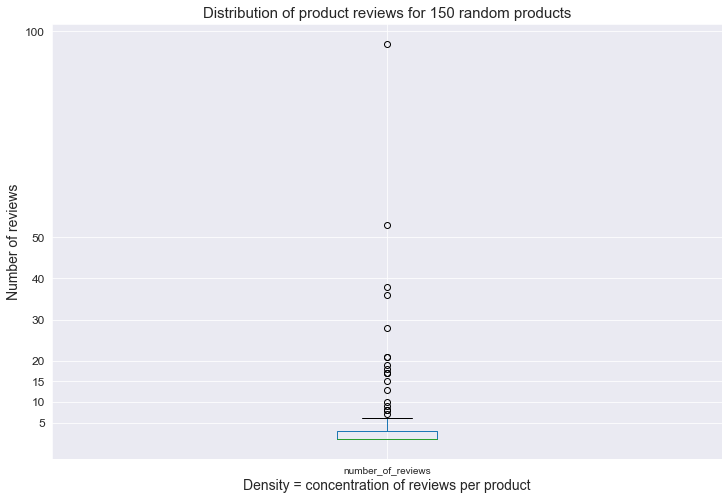

In [26]:
plt.figure(figsize=(12,8))
plt.title('Distribution of product reviews for 150 random products', size=15)
plt.yticks([5, 10, 15, 20, 30, 40, 50, 100], size = 12)
plt.ylabel('Number of reviews', size=14)
plt.xlabel('Density = concentration of reviews per product', size=14)
ecom['number_of_reviews'][:150].plot(kind='box');
plt.savefig('../assets/concentration_reviews.jpg')

In [30]:
#map no. reviews vs. no customer q's as ratio
ecom['review_to_q_ratio'] = ecom['number_of_reviews']/ecom['number_of_answered_questions']
pd.DataFrame(ecom['review_to_q_ratio'].value_counts())[:15]

,review_to_q_ratio
1.000000,3071
2.000000,1022
inf,764
0.500000,657
3.000000,557
4.000000,384
5.000000,273
0.333333,250
6.000000,215
8.000000,152


### Categories

In [27]:
#categories -- now we do not know, how the data were filtered
#during the scrape
cats = pd.DataFrame(
    ecom['amazon_category_and_sub_category'].value_counts())
print(cats.count())
cats[:50]

amazon_category_and_sub_category    256
dtype: int64


,amazon_category_and_sub_category
Die-Cast & Toy Vehicles > Toy Vehicles & Accessories > Scaled Models > Vehicles,880
0,684
Figures & Playsets > Science Fiction & Fantasy,483
Arts & Crafts > Children's Craft Kits > Bead Art & Jewellery-Making,368
Characters & Brands > Disney > Toys,346
Hobbies > Trading Cards & Accessories > Packs & Sets,317
Games > Dice & Dice Games,297
Party Supplies > Decorations > Balloons,293
"Party Supplies > Banners, Stickers & Confetti > Banners",278
Games > Card Games,242


_It looks like this dataset favors toys. It is possible -- since we do not have the methodology used during scraping availed to us -- that the products have already been filtered for specific categories._

In [132]:
#Do certain categories rank higher than others?
q = """
    SELECT DISTINCT amazon_category_and_sub_category AS category,
        average_review_rating AS star_rating
           FROM df
           WHERE star_rating <> 0
           GROUP BY category
           ORDER BY star_rating DESC
              
"""

rating_by_cat = pd.DataFrame(pysqldf(q))
rating_by_cat[:40]

,category,star_rating
0,"Sports Toys & Outdoor > Bikes, Trikes & Ride-o...",4.9
1,"Party Supplies > Banners, Stickers & Confetti ...",4.9
2,"Party Supplies > Banners, Stickers & Confetti ...",4.9
3,"Hobbies > Slot Cars, Race Tracks & Accessories...",4.9
4,"Hobbies > Slot Cars, Race Tracks & Accessories...",4.9
5,Hobbies > Model Trains & Railway Sets > Rail V...,4.9
6,Hobbies > Model Building Kits,4.9
7,Games > Casino Equipment > Game Layouts > Poke...,4.9
8,Games > Casino Equipment > Bingo Equipment,4.9
9,Games > Card Games,4.9


In [130]:
rating_by_cat.tail(20)

,category,star_rating
194,Die-Cast & Toy Vehicles > Toy Vehicles & Acces...,4.0
195,Cooking & Dining > Kitchen Tools & Gadgets > B...,4.0
196,Characters & Brands > Thunderbirds > Toys,4.0
197,Characters & Brands > Thomas & Friends > Ages ...,4.0
198,Characters & Brands > LeapFrog > LeapPad Learn...,4.0
199,Characters & Brands > Harry Potter > Toys,4.0
200,Characters & Brands > Crayola,4.0
201,Characters & Brands > Barbie > Barbie Dolls & ...,4.0
202,Characters & Brands > Barbie,4.0
203,Characters & Brands > Action Man > Toys,4.0


### Manufacturers

In [28]:
#manufs
manufs = pd.DataFrame(ecom['manufacturer'].value_counts())
print(manufs.count())
manufs[:25]

manufacturer    2646
dtype: int64


,manufacturer
LEGO,171
Disney,167
Oxford Diecast,156
Playmobil,144
Star Wars,120
Mattel,114
Hasbro,110
The Puppet Company,109
MyTinyWorld,93
Corgi,90


_As with categories, we see a predominance / prepondrance of gaming items here._

### Price

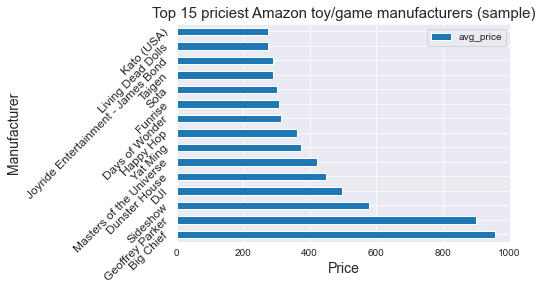

In [120]:
#look at price per manuf
def pysqldf(q):
    #add this to your script if you get tired of calling locals()
    return sqldf(q, globals())

df = ecom


q = """
    SELECT DISTINCT manufacturer, AVG(median_sale_price) AS avg_price
           FROM df
           GROUP BY manufacturer
           ORDER BY avg_price DESC
              
"""

price_by_manuf = pd.DataFrame(pysqldf(q))

price_by_manuf.set_index(
    'manufacturer')[:15].plot(kind = 'barh');
plt.title(
    'Top 15 priciest Amazon toy/game manufacturers (sample)',
size=15)
plt.xlabel('Price', size=14);
plt.ylabel('Manufacturer', size=14)
plt.yticks(size=12, rotation=45);
plt.savefig('../assets/top_manuf_by_price.jpg')

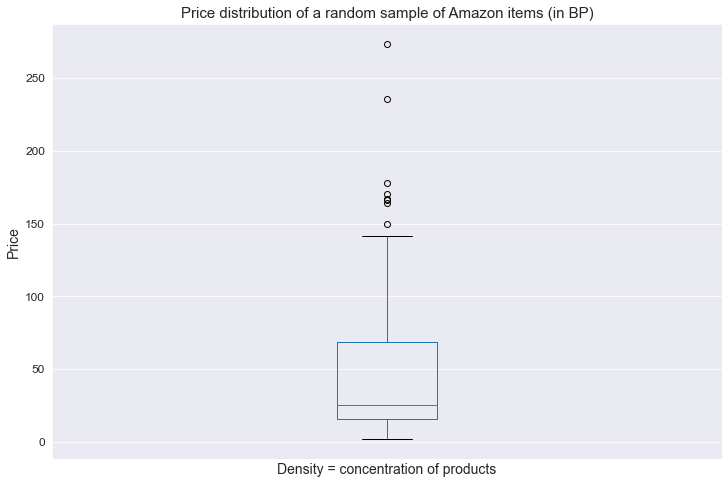

In [29]:
#price dist -- although might be more meaningful to do per category or manuf
plt.figure(figsize=(12,8))
ecom['price'][:150].plot(kind='box');
plt.xticks([]);
plt.ylabel('Price', size = 14)
plt.yticks(size=12)
plt.xlabel('Density = concentration of products', size=14)
plt.title('Price distribution of a random sample of Amazon items (in BP)', size=15);
plt.savefig('../assets/price_concentrate.jpg')

### New vs used items

NOTE: this is the number of product listings that show at least one new and at least one used product.

In [31]:
ecom['number_available_in_stock'].value_counts()[:10]
#replace w/ a search for ~like new, ~like used, and then get a count: use `string.find()`

#Gwen: use `str.contains()` rather than `str.find`, which looks for index

new = ecom['number_available_in_stock'].str.contains('new').sum()
used = ecom['number_available_in_stock'].str.contains('used').sum()

print(f'There are {new} new items sold and {used} used')

There are 7309 new items sold and 161 used


In [32]:
#new vs used (once new / used are split)
#sns.displot(data=ecom, x='number_of_reviews', kde=True, hue=''); #fill in w/ new vs used

### Sellers

In [33]:
#count of sellers
ecom.groupby(['sellers']).count() #REDO this as a dict comp if desired

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category,customers_who_bought_this_item_also_bought,description,product_information,product_description,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews,median_sale_price,review_to_q_ratio
sellers,,,,,,,,,,,,,,,,,,
0,3080,3080,3080,3080,3080,3080,3080,3080,3080,3080,3080,3080,3080,3080,3080,3080,3080,3080
"{""seller""=>[{""Seller_name_1""=>""**Steves Collectables**Fast Dispatch**UK Seller**"", ""Seller_price_1""=>""£0.38""}, {""Seller_name_2""=>""M and N Media US"", ""Seller_price_2""=>""£48.97""}]}",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
"{""seller""=>[{""Seller_name_1""=>""**Steves Collectables**Fast Dispatch**UK Seller**"", ""Seller_price_1""=>""£1.95""}, {""Seller_name_2""=>""Amazon.co.uk"", ""Seller_price_2""=>""£6.99""}, {""Seller_name_3""=>""a1 Toys"", ""Seller_price_3""=>""£11.32""}, {""Seller_name_4""=>""Beanie Games"", ""Seller_price_4""=>""£6.99""}]}",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
"{""seller""=>[{""Seller_name_1""=>""**Steves Collectables**Fast Dispatch**UK Seller**"", ""Seller_price_1""=>""£10.34""}, {""Seller_name_2""=>""ARGOSYTOYS home delivery service UK and Worldwide. Established 1947."", ""Seller_price_2""=>""£14.97""}, {""Seller_name_3""=>""DALY store"", ""Seller_price_3""=>""£52.95""}]}",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
"{""seller""=>[{""Seller_name_1""=>""**Steves Collectables**Fast Dispatch**UK Seller**"", ""Seller_price_1""=>""£12.95""}, {""Seller_name_2""=>""Firestorm Cards"", ""Seller_price_2""=>""£21.99""}, {""Seller_name_3""=>""M and N Media US"", ""Seller_price_3""=>""£23.54""}]}",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"{""seller""=>{""Seller_name_1""=>""verkauf1"", ""Seller_price_1""=>""£69.99""}}",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
"{""seller""=>{""Seller_name_1""=>""verkauf1"", ""Seller_price_1""=>""£74.99""}}",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
"{""seller""=>{""Seller_name_1""=>""verkauf1"", ""Seller_price_1""=>""£90.99""}}",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [34]:
##Gwen's code - number of different sellers for a single product:
ecom['sellers'][0].split('Seller_price_')[-1][0]

'5'

In [35]:
#Gwen's code
# all the prices for a single item
# map to create column
[float(x.split(
    '"')[0].replace(
    "'",'')) for x in ecom['sellers'][0].split('£')[1:]]

[3.42, 0.19, 9.99, 8.0, 37.62]

_Diff. conditions._

In [36]:
#of ratings per seller?

### Customers also bought...

In [37]:
#whether ratings affect also bought products? but need to extract url...

## Feature engineering

We need to convert things like ratings so that the modeling works correctly.

The plan:

* Categorize / one hot encode the ratings column 

In [39]:
#one-hot encode ratings column on a scale of 1-5? Or is target / OK as
#ordinal?

In [40]:
#move out new vs. used items into sep. columns (binarize as new_only);
#or can merely filter by ...

## NLP

Open questions:

* Sentiment of reviews
* Does sentiment correspond to star rating?
* Most interesting question bi-grams
* Most interesting review bi-grams

In [41]:
#vectorize text

## Modeling - regression

In [42]:
#reviews
#price
#category

## Evaluation

## Conclusions & next steps